In [1]:
import tensorflow as tf
import gc
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Compute dtype: float16
Variable dtype: float32


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_directory = "/content/drive/MyDrive/Thesis Dataset/train"
test_directory = "/content/drive/MyDrive/Thesis Dataset/test"
validation_directory = "/content/drive/MyDrive/Thesis Dataset/validation"

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

In [5]:
DATADIR = train_directory

CATEGORIES = ["ADI", "BACK","DEB", "LYM","MUC", "MUS","NORM", "STR","TUM"]

training_data = []

IMG_SIZE = 50

def create_training_data():
    for category in CATEGORIES: 

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category) 

        for img in tqdm(os.listdir(path)): 
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                print(e)
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 10010/10010 [04:07<00:00, 40.52it/s]

69085


In [6]:
DATADIR = test_directory

CATEGORIES = ["ADI", "BACK","DEB", "LYM","MUC", "MUS","NORM", "STR","TUM"]

testing_data = []

IMG_SIZE = 50

def create_training_data():
    for category in CATEGORIES: 

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category) 

        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                
                testing_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                print(e)
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

100%|██████████| 1452/1452 [00:23<00:00, 62.46it/s] 


In [7]:
import random

random.shuffle(training_data)
random.shuffle(testing_data)

In [8]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
    

X_train = np.array(X)
X_train = X_train/255.0
y_train = np.array(y)


X_t = []
y_t = []

for features,label in testing_data:
    X_t.append(features)
    y_t.append(label)

X_test = np.array(X_t)
X_test = X_test/255.0
y_test = np.array(y_t)

In [9]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
len(X_test)

10392

In [11]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [12]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]
    
    data = list(zip(image_list, label_list))

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [13]:
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

In [14]:

def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [15]:
#process and batch the training data for each client
clients_batched = dict()
co = 0
for (client_name, data) in clients.items():
    co+=1
    clients_batched[client_name] = batch_data(data)
    
   
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [16]:
clients_batched

{'client_1': <BatchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>,
 'client_10': <BatchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>,
 'client_2': <BatchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>,
 'client_3': <BatchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>,
 'client_4': <BatchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>,
 'client_5': <BatchDataset element_spec=(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))

In [17]:
del(X_train)
del(y_train)
del(training_data)
gc.collect()

103

In [18]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers

In [19]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-vlpefv5m
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-vlpefv5m
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 6.9 MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20046 sha256=e40e6a94dd7d6685dcada9d950b1b7299ee130a0bc7babf2302eda450cc5d80d
  Stored in directory: /tmp/pip-ephem-wheel-cache-j6419b05/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers


In [20]:
from classification_models.tfkeras import Classifiers



class SimpleModel:
    def build(self):

        # image_size = [75, 75]
        # model1 = VGG16(include_top= False, input_shape=image_size+[3], weights='imagenet')
        # headModel = model1.output
        # headModel = layers.Flatten()(headModel)
        # headModel = Dense(1024, activation="relu")(headModel)
        # headModel = Dropout(0.5)(headModel)
        # headModel = Dense(9, activation="softmax")(headModel)
        # new_model = Model(inputs=model1.input, outputs=headModel)

        # model2 = VGG19(include_top= False, input_shape=image_size+[3], weights='imagenet')
        # headModel = model2.output
        # headModel = layers.Flatten()(headModel)
        # headModel = Dense(1024, activation="relu")(headModel)
        # headModel = Dropout(0.5)(headModel)
        # headModel = Dense(9, activation="softmax")(headModel)
        # new_model1 = Model(inputs=model2.input, outputs=headModel)



        # model3 = InceptionV3(include_top= False, input_shape=image_size+[3], weights='imagenet')
        # headModel = model3.output
        # headModel = layers.Flatten()(headModel)
        # headModel = Dense(1024, activation="relu")(headModel)
        # headModel = Dropout(0.5)(headModel)
        # headModel = Dense(9, activation="softmax")(headModel)
        # new_model2 = Model(inputs=model3.input, outputs=headModel)

        # model4 = ResNet50(include_top= False, input_shape=image_size+[3], weights='imagenet')
        # headModel = model4.output
        # headModel = layers.Flatten()(headModel)
        # headModel = Dense(1024, activation="relu")(headModel)
        # headModel = Dropout(0.5)(headModel)
        # headModel = Dense(9, activation="softmax")(headModel)
        # new_model3 = Model(inputs=model4.input, outputs=headModel)

        image_size = [50, 50]
        ResNeXt50, preprocess_input = Classifiers.get('resnext50')
        model5 = ResNeXt50(include_top = False, input_shape=image_size+[3], weights='imagenet')
        headModel = model5.output
        headModel = layers.Flatten()(headModel)
        headModel = Dense(1024, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)
        headModel = Dense(9, activation="softmax")(headModel)
        new_model4 = Model(inputs=model5.input, outputs=headModel)



        
        inputs = keras.Input(shape=(50,50,3))
        
        # outputs = layers.average([new_model(inputs),new_model1(inputs),
        #                           new_model2(inputs),new_model3(inputs),
        #                           new_model4(inputs)])

        outputs = new_model4(inputs)
        ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
        
        
        return ensemble_model

In [21]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import SGD
optimizer = Adam(lr=.00001)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    print(global_count)
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_local_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | local_acc: {:.3%} | local_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [23]:
def test_global_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [24]:
smlp_global = SimpleModel()
global_model = smlp_global.build()
global_model.summary()
# from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score

local_model = smlp_global.build()
local_model.compile(optimizer= 'adam', loss=loss, metrics=metrics)

94437376/94428600 [==============================] - 27s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 model_1 (Functional)        (None, 9)                 31446994  
                                                                 
Total params: 31,446,994
Trainable params: 31,378,764
Non-trainable params: 68,230
_________________________________________________________________
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [25]:
import multiprocessing
comms_round = 20
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    
    
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    #random.shuffle(client_names)
    
    #loop through each client and create new local model
    count = 0
    for client in client_names:
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=1)
        test_local_model(X_test, y_test, local_model, comm_round)
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        
        # K.clear_session()
        # gc.collect()
        #del local_model
    
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_global_model(X_test, Y_test, global_model, comm_round)

216/216 [==============================] - 78s 145ms/step - loss: 1.7716 - categorical_accuracy: 0.6212
comm_round: 0 | local_acc: 10.287% | local_loss: 2.267578125
69120
216/216 [==============================] - 31s 145ms/step - loss: 2.0634 - categorical_accuracy: 0.4919
comm_round: 0 | local_acc: 10.287% | local_loss: 2.267578125
69120
216/216 [==============================] - 31s 144ms/step - loss: 3.4380 - categorical_accuracy: 0.2632
comm_round: 0 | local_acc: 10.287% | local_loss: 2.267578125
69120
216/216 [==============================] - 31s 144ms/step - loss: 3.5052 - categorical_accuracy: 0.3172
comm_round: 0 | local_acc: 10.287% | local_loss: 2.267578125
69120
216/216 [==============================] - 31s 145ms/step - loss: 3.5386 - categorical_accuracy: 0.3978
comm_round: 0 | local_acc: 9.623% | local_loss: 2.275390625
69120
216/216 [==============================] - 31s 143ms/step - loss: 3.8318 - categorical_accuracy: 0.3154
comm_round: 0 | local_acc: 11.201% | local

In [26]:
# Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




predict_x=global_model.predict(X_test) 
y_pred=np.argmax(predict_x,axis=1)

y_testreport=np.argmax(y_test,axis=1)


from sklearn.metrics import classification_report, confusion_matrix

#Print Classification Report

print('Classification Report')
print(classification_report(y_testreport, y_pred, target_names=["ADI", "BACK","DEB", "LYM","MUC", "MUS","NORM", "STR","TUM"]))

Classification Report
              precision    recall  f1-score   support

         ADI       1.00      0.98      0.99      1000
        BACK       0.99      1.00      1.00      1069
         DEB       0.93      0.94      0.94      1207
         LYM       0.96      1.00      0.98      1233
         MUC       0.93      0.99      0.96      1026
         MUS       0.97      0.94      0.95      1364
        NORM       1.00      0.92      0.96       877
         STR       0.93      0.90      0.91      1164
         TUM       0.95      0.98      0.96      1452

    accuracy                           0.96     10392
   macro avg       0.96      0.96      0.96     10392
weighted avg       0.96      0.96      0.96     10392



Confusion Matrix
Confusion matrix, without normalization


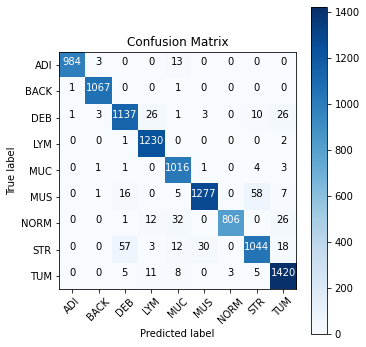

In [27]:
import itertools
print('Confusion Matrix')
cm = confusion_matrix(y_testreport, y_pred)
plot_confusion_matrix(cm, ["ADI", "BACK","DEB", "LYM","MUC", "MUS","NORM", "STR","TUM"], title='Confusion Matrix')